In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from typing import List, Tuple, Optional, Set
import time
import tracemalloc


In [3]:
# Generate Dataset points

def generate_random_points(n_points=50, x_range=(0, 1), y_range=(0, 1), seed=None):
    if seed is not None:
        np.random.seed(seed)

    x = np.random.uniform(x_range[0], x_range[1], n_points)
    y = np.random.uniform(y_range[0], y_range[1], n_points)
    
    points = np.column_stack((x, y))
    return points

def generate_gaussian_points(n_points=50, mean=(0.5, 0.5), cov=None, seed=None):
    """2D Gaussian distributed points."""
    if seed is not None:
        np.random.seed(seed)
    if cov is None:
        cov = [[0.02, 0.0], [0.0, 0.02]]  # isotropic default covariance
    points = np.random.multivariate_normal(mean, cov, n_points)
    return np.clip(points, 0, 1)  # keep in [0,1] range


def generate_poisson_disc_points(radius=0.2, x_range=(0, 1), y_range=(0, 1), k=30, seed=None):
    """
    Poisson disk sampling (Blue noise).
    - radius: minimum distance between points.
    - k: number of candidates per active point.
    """
    if seed is not None:
        np.random.seed(seed)

    width, height = x_range[1] - x_range[0], y_range[1] - y_range[0]
    cell_size = radius / np.sqrt(2)
    grid_w, grid_h = int(np.ceil(width / cell_size)), int(np.ceil(height / cell_size))
    grid = -np.ones((grid_h, grid_w), dtype=int)
    points = []
    active_list = []

    def in_bounds(p):
        return x_range[0] <= p[0] <= x_range[1] and y_range[0] <= p[1] <= y_range[1]

    def grid_coords(p):
        return int((p[0] - x_range[0]) / cell_size), int((p[1] - y_range[0]) / cell_size)

    def too_close(p):
        gx, gy = grid_coords(p)
        for i in range(max(gy - 2, 0), min(gy + 3, grid_h)):
            for j in range(max(gx - 2, 0), min(gx + 3, grid_w)):
                idx = grid[i, j]
                if idx != -1:
                    dist = np.linalg.norm(points[idx] - p)
                    if dist < radius:
                        return True
        return False

    # Initial point
    first_point = np.array([
        np.random.uniform(x_range[0], x_range[1]),
        np.random.uniform(y_range[0], y_range[1])
    ])
    points.append(first_point)
    active_list.append(0)
    gx, gy = grid_coords(first_point)
    grid[gy, gx] = 0

    while active_list:
        idx = np.random.choice(active_list)
        base_point = points[idx]
        found = False
        for _ in range(k):
            theta = np.random.uniform(0, 2 * np.pi)
            r = np.random.uniform(radius, 2 * radius)
            new_point = base_point + np.array([r * np.cos(theta), r * np.sin(theta)])
            if in_bounds(new_point) and not too_close(new_point):
                points.append(new_point)
                gx, gy = grid_coords(new_point)
                grid[gy, gx] = len(points) - 1
                active_list.append(len(points) - 1)
                found = True
                break
        if not found:
            active_list.remove(idx)
    return np.array(points)


def generate_clustered_points(n_points=100, n_clusters=3, x_range=(0, 1), y_range=(0, 1), seed=None):
    """Multiple dense clusters with sparse regions between them."""
    if seed is not None:
        np.random.seed(seed)
    cluster_centers = np.random.uniform([x_range[0], y_range[0]], [x_range[1], y_range[1]], (n_clusters, 2))
    points_per_cluster = n_points // n_clusters
    remainder = n_points % n_clusters
    points = []
    for i, center in enumerate(cluster_centers):
        size = points_per_cluster + (1 if i < remainder else 0)
        cov = np.diag(np.random.uniform(0.001, 0.01, 2))
        cluster = np.random.multivariate_normal(center, cov, size)
        points.append(cluster)
    return np.clip(np.vstack(points), 0, 1)

In [4]:
def triangulate_bw(points):
    """Bowyer-Watson triangulation implementation.

    points: (n,2) array-like
    returns: (m,3) array of triangles (indices into input points)
    """
    pts = np.asarray(points, dtype=float)
    if pts.ndim != 2 or pts.shape[1] != 2:
        raise ValueError('points must be an (n,2) array')

    n = len(pts)
    if n < 3:
        return np.empty((0, 3), dtype=int)

    # Build a supertriangle that contains all points
    minx, miny = pts.min(axis=0)
    maxx, maxy = pts.max(axis=0)
    dx = maxx - minx
    dy = maxy - miny
    dmax = max(dx, dy)
    midx = (minx + maxx) / 2.0
    midy = (miny + maxy) / 2.0
    p1 = np.array([midx - 20 * dmax, midy - dmax])
    p2 = np.array([midx, midy + 20 * dmax])
    p3 = np.array([midx + 20 * dmax, midy - dmax])
    pts_ext = np.vstack([pts, p1, p2, p3])
    super_idx = (n, n + 1, n + 2)

    def circumcenter_and_r2(a, b, c):
        A = b - a
        B = c - a
        denom = 2.0 * (A[0] * B[1] - A[1] * B[0])
        if abs(denom) < 1e-12:
            return (np.array([np.inf, np.inf]), np.inf)
        a_len = np.dot(A, A)
        b_len = np.dot(B, B)
        ux = a[0] + (B[1] * a_len - A[1] * b_len) / denom
        uy = a[1] + (-B[0] * a_len + A[0] * b_len) / denom
        center = np.array([ux, uy])
        r2 = np.sum((center - a) ** 2)
        return center, r2

    def in_circ(tri, p):
        a = pts_ext[tri[0]]
        b = pts_ext[tri[1]]
        c = pts_ext[tri[2]]
        center, r2 = circumcenter_and_r2(a, b, c)
        if r2 == np.inf:
            return False
        return np.sum((p - center) ** 2) <= r2 + 1e-12

    triangles = [super_idx]

    for i_pt in range(n):
        p = pts_ext[i_pt]
        bad = []
        for tri in triangles:
            if in_circ(tri, p):
                bad.append(tri)
        edge_count = {}
        for tri in bad:
            edges = [(tri[0], tri[1]), (tri[1], tri[2]), (tri[2], tri[0])]
            for a, b in edges:
                key = (min(a, b), max(a, b))
                edge_count[key] = edge_count.get(key, 0) + 1
        boundary = [e for e, c in edge_count.items() if c == 1]
        triangles = [t for t in triangles if t not in bad]
        for edge in boundary:
            a, b = edge
            triangles.append((a, b, i_pt))

    result = [t for t in triangles if not (t[0] >= n or t[1] >= n or t[2] >= n)]
    return np.array(result, dtype=int)

In [6]:
"""

The divide-and-conquer algorithm for computing Delaunay triangulation of a set of points.

"""


edges = [] # container for edges

def triangulate_dnc(S):
    """Assumes S is a list of points of form (x, y).
    Returns a list of edges that form a Delaunay triangulation of S."""

    if len(S) < 2:
        print("Must be at least two points.")
        return
    
    global edges
    edges = []
    S = np.asarray(S, dtype=np.float64)
    
    # Sort points by x coordinate, y is a tiebreaker.
    S.view(dtype=[('f0', S.dtype), ('f1', S.dtype)]).sort(order=['f0', 'f1'], axis=0)
    
    # Remove duplicates.
    dupes = [i for i in range(1, len(S)) if S[i-1][0] == S[i][0] and S[i-1][1] == S[i][1]]
    if dupes:
        S = np.delete(S, dupes, 0)

    triangulate(S)
    edges = [e for e in edges if e.data is None]  # clean the garbage

    return edges


# -----------------------------------------------------------------
# Quad edge data structure.


class Edge:
    """A directed edge: org -> dest.
    When traversing edge ring: Next is CCW, Prev is CW."""

    def __init__(self, org, dest):
        self.org   = org
        self.dest  = dest
        self.onext = None
        self.oprev = None
        self.sym   = None    # symmetrical counterpart of this edge
        self.data  = None  

    def __str__(self):
        s = str(self.org) + ', ' + str(self.dest)
        if self.data is None:
            return s
        else:
            return s + ' ' + str(self.data)


def triangulate(S):
    """Computes the Delaunay triangulation of a point set S and returns two edges, le and re,
    which are the counterclockwise convex hull edge out of the leftmost vertex and the clockwise
    convex hull edge out of the rightmost vertex, respectively."""

    if len(S) == 2:
        a = make_edge(S[0], S[1])
        return a, a.sym

    elif len(S) == 3:
        # Create edges a connecting p1 to p2 and b connecting p2 to p3.
        p1, p2, p3 = S[0], S[1], S[2]
        a = make_edge(p1, p2)
        b = make_edge(p2, p3)
        splice(a.sym, b)

        # Close the triangle.
        if right_of(p3, a):
            connect(b, a)
            return a, b.sym
        elif left_of(p3, a):
            c = connect(b, a)
            return c.sym, c
        else:  # the three points are collinear
            return a, b.sym

    else:
        # Recursively subdivide S.
        m = (len(S) + 1) // 2
        L, R = S[:m], S[m:]
        ldo, ldi = triangulate(L)
        rdi, rdo = triangulate(R)

        # Compute the upper common tangent of L and R.
        while True:
            if right_of(rdi.org, ldi):
                ldi = ldi.sym.onext
            elif left_of(ldi.org, rdi):
                rdi = rdi.sym.oprev
            else:
                break

        # Create a first cross edge base from rdi.org to ldi.org.
        base = connect(ldi.sym, rdi)

        # Adjust ldo and rdo
        if ldi.org[0] == ldo.org[0] and ldi.org[1] == ldo.org[1]:
            ldo = base
        if rdi.org[0] == rdo.org[0] and rdi.org[1] == rdo.org[1]:
            rdo = base.sym

        # Merge.
        while True:
            # Locate the first R and L points to be encountered by the diving bubble.
            rcand, lcand = base.sym.onext, base.oprev
            # If both lcand and rcand are invalid, then base is the lower common tangent.
            v_rcand, v_lcand = right_of(rcand.dest, base), right_of(lcand.dest, base)
            if not (v_rcand or v_lcand):
                break
            # Delete R edges out of base.dest that fail the circle test.
            if v_rcand:
                while right_of(rcand.onext.dest, base) and \
                      in_circle(base.dest, base.org, rcand.dest, rcand.onext.dest) == 1:
                    t = rcand.onext
                    delete_edge(rcand)
                    rcand = t
            # Symmetrically, delete L edges.
            if v_lcand:
                while right_of(lcand.oprev.dest, base) and \
                      in_circle(base.dest, base.org, lcand.dest, lcand.oprev.dest) == 1:
                    t = lcand.oprev
                    delete_edge(lcand)
                    lcand = t
            # The next cross edge is to be connected to either lcand.dest or rcand.dest.
            # If both are valid, then choose the appropriate one using the in_circle test.
            if not v_rcand or \
               (v_lcand and in_circle(rcand.dest, rcand.org, lcand.org, lcand.dest) == 1):
                # Add cross edge base from rcand.dest to base.dest.
                base = connect(lcand, base.sym)
            else:
                # Add cross edge base from base.org to lcand.dest
                base = connect(base.sym, rcand.sym)

        return ldo, rdo


# -----------------------------------------------------------------
# Predicates


def in_circle(a, b, c, d):
    """Does d lie inside of circumcircle abc?"""
    a1, a2 = a[0]-d[0], a[1]-d[1]
    b1, b2 = b[0]-d[0], b[1]-d[1]
    c1, c2 = c[0]-d[0], c[1]-d[1]
    a3, b3, c3 = a1**2 + a2**2, b1**2 + b2**2, c1**2 + c2**2
    det = a1*b2*c3 + a2*b3*c1 + a3*b1*c2 - (a3*b2*c1 + a1*b3*c2 + a2*b1*c3)
    return det < 0


def right_of(p, e):
    """Does point p lie to the right of the line of edge e?"""
    a, b = e.org, e.dest
    det = (a[0]-p[0]) * (b[1]-p[1]) - (a[1]-p[1]) * (b[0]-p[0])
    return det > 0


def left_of(p, e):
    """Does point p lie to the left of the line of edge e?"""
    a, b = e.org, e.dest
    det = (a[0]-p[0]) * (b[1]-p[1]) - (a[1]-p[1]) * (b[0]-p[0])
    return det < 0


# -----------------------------------------------------------------
# Topological operators


def make_edge(org, dest):
    """Creates a new edge. Assumes org and dest are points."""

    global edges
    e  = Edge(org, dest)
    es = Edge(dest, org)
    e.sym, es.sym = es, e  # make edges mutually symmetrical
    e.onext, e.oprev = e, e
    es.onext, es.oprev = es, es
    edges.append(e)
    return e


def splice(a, b):
    """Combines distinct edge rings / breaks the same ring in two pieces. Merging / tearing goes
    between a and a.onext through a.org to between b and b.onext."""

    if a == b:
        print("Splicing edge with itself, ignored: {}.".format(a))
        return

    a.onext.oprev, b.onext.oprev = b, a
    a.onext, b.onext = b.onext, a.onext


def connect(a, b):
    """Adds a new edge e connecting the destination of a to the origin of b, in such a way that
    a Left = e Left = b Left after the connection is complete."""
    e = make_edge(a.dest, b.org)
    splice(e, a.sym.oprev)
    splice(e.sym, b)
    return e


def delete_edge(e):
    """Disconnects the edge e from the rest of the structure (this may cause the rest of the
    structure to fall apart in two separate components)."""
    splice(e, e.oprev)
    splice(e.sym, e.sym.oprev)
    e.data, e.sym.data = True, True




In [7]:

import random
import sys
from collections import defaultdict, deque
import math

# ================================================
#  PREDICATES (Geometry Math)
# ================================================

EPS = 1e-10

def orient_ric(points, i, j, k):
    """
    Returns > 0 if CCW, < 0 if CW, 0 if collinear.
    Uses indices i, j, k to access points array.
    """
    a, b, c = points[i], points[j], points[k]
    return (b[0]-a[0])*(c[1]-a[1]) - (b[1]-a[1])*(c[0]-a[0])

def in_circle_RIC(points, i, j, k, l):
    """
    Returns True if point l is inside circumcircle of triangle i,j,k.
    """
    a, b, c, d = points[i], points[j], points[k], points[l]
    ax, ay = a[0]-d[0], a[1]-d[1]
    bx, by = b[0]-d[0], b[1]-d[1]
    cx, cy = c[0]-d[0], c[1]-d[1]

    det = (ax*ax+ay*ay)*(bx*cy - cx*by) \
        - (bx*bx+by*by)*(ax*cy - cx*ay) \
        + (cx*cx+cy*cy)*(ax*by - bx*ay)
        
    return det > EPS

# ================================================
#  OPTIMIZED HISTORY DAG
# ================================================

class HistoryDAG:
    def __init__(self):
        self.children = {} # Key: tid, Value: list of child_tids
        self.root = None

    def set_root(self, tid):
        self.root = tid

    def add_split(self, parent_tid, child_tids):
        self.children[parent_tid] = list(child_tids)

    def add_flip(self, parent1, parent2, child1, child2):
        self.children[parent1] = [child1, child2]
        self.children[parent2] = [child1, child2]

    def find_containing_triangle(self, points, triangles, alive, p_idx):
        curr = self.root
        
        # Descend the DAG until we hit a live triangle
        while curr not in alive:
            found_next = False
            children = self.children.get(curr, [])
            
            for child_id in children:
                # Get indices of the child triangle
                i, j, k = triangles[child_id]
                
                # Check if point is inside this child
                # (Barycentric orientation check)
                if (orient_ric(points, i, j, p_idx) >= -EPS and 
                    orient_ric(points, j, k, p_idx) >= -EPS and 
                    orient_ric(points, k, i, p_idx) >= -EPS):
                    
                    curr = child_id
                    found_next = True
                    break
            
            if not found_next:
                # Robustness Fallback: Linear search if precision errors occur
                for t in alive:
                    i, j, k = triangles[t]
                    if (orient_ric(points, i, j, p_idx) >= -EPS and 
                        orient_ric(points, j, k, p_idx) >= -EPS and 
                        orient_ric(points, k, i, p_idx) >= -EPS):
                        return t
                return None

        return curr

# ================================================
#  TRIANGLE & EDGE HELPERS
# ================================================

def edge_key_RIC(u, v):
    return (u, v) if u < v else (v, u)

_tid_counter = 0
def new_tid():
    global _tid_counter
    t = _tid_counter
    _tid_counter += 1
    return t

def add_triangle_RIC(points, triangles, alive, edge_map, i, j, k):
    # Ensure Counter-Clockwise Order
    if orient_ric(points, i, j, k) < 0:
        i, j = j, i 
        
    tid = new_tid()
    triangles[tid] = (i, j, k)
    alive.add(tid)
    
    # Map edges to this triangle
    for u, v in [(i, j), (j, k), (k, i)]:
        edge_map[edge_key_RIC(u, v)].add(tid)
        
    return tid

def kill_triangle_RIC(alive, edge_map, triangles, tid):
    if tid in alive:
        alive.remove(tid)
        tri = triangles[tid]
        for u, v in [(tri[0], tri[1]), (tri[1], tri[2]), (tri[2], tri[0])]:
            key = edge_key_RIC(u, v)
            if key in edge_map:
                edge_map[key].discard(tid)
                if not edge_map[key]:
                    del edge_map[key]

# ================================================
#  FLIP & LEGALIZE
# ================================================

def flip_edge_RIC(points, triangles, alive, edge_map, dag, t1, t2, u, v):
    tri1 = triangles[t1]
    tri2 = triangles[t2]
    
    # Identify opposite vertices
    opp1 = [x for x in tri1 if x != u and x != v][0]
    opp2 = [x for x in tri2 if x != u and x != v][0]

    # New triangles: (u, opp1, opp2) and (v, opp2, opp1)
    n1 = add_triangle_RIC(points, triangles, alive, edge_map, u, opp1, opp2)
    n2 = add_triangle_RIC(points, triangles, alive, edge_map, v, opp2, opp1)

    # Update DAG
    dag.add_flip(t1, t2, n1, n2)
    
    # Kill old
    kill_triangle_RIC(alive, edge_map, triangles, t1)
    kill_triangle_RIC(alive, edge_map, triangles, t2)

    return n1, n2

def legalize_RIC(points, triangles, alive, edge_map, dag, tid):
    if tid not in alive: return

    tri = triangles[tid]
    # Check edges (copy list because structure changes during loop)
    edges = [(tri[0], tri[1]), (tri[1], tri[2]), (tri[2], tri[0])]

    for u, v in edges:
        key = edge_key_RIC(u, v)
        neighbors = edge_map.get(key, set())
        
        neighbor_tid = None
        for n in neighbors:
            if n != tid:
                neighbor_tid = n
                break
        
        if neighbor_tid is None: continue 

        # Find opposite vertex in neighbor
        ntri = triangles[neighbor_tid]
        opp_node = [x for x in ntri if x != u and x != v][0]

        # Find opposite vertex in current
        current_opp = [x for x in tri if x != u and x != v][0]

        # Delaunay Check: Is opp_node inside circumcircle of current triangle?
        if in_circle_RIC(points, u, v, current_opp, opp_node):
            new_t1, new_t2 = flip_edge_RIC(points, triangles, alive, edge_map, dag, tid, neighbor_tid, u, v)
            legalize_RIC(points, triangles, alive, edge_map, dag, new_t1)
            legalize_RIC(points, triangles, alive, edge_map, dag, new_t2)
            return

# ================================================
#  MAIN DRIVER
# ================================================

def triangulate_ric(points_input):
    """
    Returns list of tuples (i, j, k) representing indices of vertices.
    """
    global _tid_counter
    _tid_counter = 0

    # Ensure inputs are standard list of tuples
    pts = [tuple(p) for p in points_input]
    n = len(pts)
    
    # Create Supertriangle
    xs = [p[0] for p in pts]
    ys = [p[1] for p in pts]
    dx, dy = max(xs)-min(xs), max(ys)-min(ys)
    delta = max(dx, dy) * 10
    mid_x, mid_y = (min(xs)+max(xs))/2, (min(ys)+max(ys))/2
    
    p1 = (mid_x - 20 * delta, mid_y - delta)
    p2 = (mid_x, mid_y + 20 * delta)
    p3 = (mid_x + 20 * delta, mid_y - delta)
    
    pts.extend([p1, p2, p3])
    
    # Init Structures
    triangles = {}     
    alive = set()      
    edge_map = defaultdict(set) # <--- FIXED KEYERROR
    dag = HistoryDAG() 
    
    root_id = add_triangle_RIC(pts, triangles, alive, edge_map, n, n+1, n+2)
    dag.set_root(root_id)

    # Insert Points
    indices = list(range(n))
    random.shuffle(indices)

    for i in indices:
        # Point Location
        tid = dag.find_containing_triangle(pts, triangles, alive, i)
        
        if tid is None: continue

        # Split
        a, b, c = triangles[tid]
        kill_triangle_RIC(alive, edge_map, triangles, tid)
        
        t1 = add_triangle_RIC(pts, triangles, alive, edge_map, a, b, i)
        t2 = add_triangle_RIC(pts, triangles, alive, edge_map, b, c, i)
        t3 = add_triangle_RIC(pts, triangles, alive, edge_map, c, a, i)
        
        dag.add_split(tid, [t1, t2, t3])
        
        # Legalize
        legalize_RIC(pts, triangles, alive, edge_map, dag, t1)
        legalize_RIC(pts, triangles, alive, edge_map, dag, t2)
        legalize_RIC(pts, triangles, alive, edge_map, dag, t3)

    # Extract Final Triangles (Filter out supertriangle indices >= n)
    final_triangles = []
    for tid in alive:
        a, b, c = triangles[tid]
        if a < n and b < n and c < n:
            final_triangles.append((a, b, c)) # Return INDICES
            
    return final_triangles



In [9]:
from __future__ import print_function
import math

def CalcDist(a, b):
	#Pythagorean theorem
	return ((a[0] - b[0]) ** 2. + (a[1] - b[1]) ** 2.) ** 0.5

def CalcDistCached(pts, a, b, distCache):
	ptIds = (a, b)
	distId = min(ptIds), max(ptIds)
	if distId in distCache:
		return distCache[distId]
	
	dist = CalcDist(pts[a], pts[b])
	distCache[distId] = dist
	return dist

def RadialDistance(pts, seedIndex):
	dists = []
	seedPt = pts[seedIndex]

	for ptNum, pt in enumerate(pts):
		dist = CalcDist(pt, seedPt)
		dists.append((dist, ptNum))

	dists.sort()
	return dists

def FindSmallestCircumCircle(pts, firstIndex, secondIndex):
	
	a = CalcDist(pts[firstIndex], pts[secondIndex])
	if a == 0.:
		raise Exception("Zero distance between duplicate points is not allowed")

	diams = []
	for ptNum, pt in enumerate(pts):
		if ptNum == firstIndex:
			continue
		if ptNum == secondIndex:
			continue
		b = CalcDist(pts[firstIndex], pts[ptNum])
		c = CalcDist(pts[secondIndex], pts[ptNum])

		#https://en.wikipedia.org/wiki/Heron%27s_formula#Numerical_stability
		x1 = (a+(b+c))
		x2 = (c-(a-b))
		x3 = (c+(a-b))
		x4 = (a+(b-c))
		x = x1*x2*x3*x4
		if x > 0.:
			sqrtx = x**0.5
			if sqrtx > 0.:
				diam = 0.5*a*b*c/sqrtx
				diams.append((diam, ptNum))
				#print(ptNum, a, b, c)
			else:
				#Prevent division by zero
				diams.append((float("inf"), ptNum))
		else:
			#Numerical instability detected
			diams.append((float("inf"), ptNum))
	
	diams.sort()
	return diams

def CircumCircleCentre(pta, ptb, ptc):
	#https://en.wikipedia.org/wiki/Circumscribed_circle#Cartesian_coordinates
	pta2 = (pta[0]**2.+pta[1]**2.)
	ptb2 = (ptb[0]**2.+ptb[1]**2.)
	ptc2 = (ptc[0]**2.+ptc[1]**2.)

	d = 2.*(pta[0]*(ptb[1]-ptc[1])+ptb[0]*(ptc[1]-pta[1])+ptc[0]*(pta[1]-ptb[1]))
	if d == 0.:
		raise RuntimeError("Could not find circumcircle centre")

	ux = (pta2*(ptb[1]-ptc[1]) + ptb2*(ptc[1]-pta[1]) + ptc2*(pta[1]-ptb[1])) / d
	uy = (pta2*(ptc[0]-ptb[0]) + ptb2*(pta[0]-ptc[0]) + ptc2*(ptb[0]-pta[0])) / d

	return ux, uy

def RightHandedCheck(pts, pt1, pt2, pt3):
	vec21 = (pts[pt1][0] - pts[pt2][0], pts[pt1][1] - pts[pt2][1])
	vec23 = (pts[pt3][0] - pts[pt2][0], pts[pt3][1] - pts[pt2][1])
	return vec21[0] * vec23[1] - vec21[1] * vec23[0]

def FormTriangles(pts, seedTriangle, orderToAddPts):
	#print(pts)
	#print(seedTriangle)
	#print(orderToAddPts)
	
	triangles = [seedTriangle]
	hull = seedTriangle[:]

	for ptToAdd in orderToAddPts:
		#print("adding point", ptToAdd, pts[ptToAdd])

		#Check which hull faces are visible
		visInd = []
		visList = []
		for hInd in range(len(hull)):
			#print(pts[hull[hInd]], pts[hull[(hInd+1) % len(hull)]])
			vis = RightHandedCheck(pts, hull[hInd], hull[(hInd+1) % len(hull)], ptToAdd)
			#print("vis", hInd, vis)
			visList.append(vis)
			if vis <= 0.:
				visInd.append(hInd)

		if len(visInd) == 0:
			raise Exception("No hull sides visible")

		#Check for range of sides that are visible
		firstSide = 0
		while firstSide in visInd:
			firstSide += 1
			if firstSide >= len(hull):
				raise Exception("No sides are not visible to point")

		while firstSide not in visInd:
			firstSide = (firstSide + 1) % len(hull)
		
		lastSide = firstSide
		while (lastSide+1) % len(hull) in visInd:
			lastSide = (lastSide+1) % len(hull)

		#Get copy of retained section of hull
		cursor = (lastSide + 1) % len(hull)
		newHull = []
		iterating = True
		while iterating:
			newHull.append(hull[cursor])
			if cursor in visInd:
				iterating = False
			cursor = (cursor + 1) % len(hull)

		#Add new point to hull
		newHull.append(ptToAdd)

		#Form new triangles
		cursor = firstSide
		iterating = True
		while iterating:
			tri = (hull[cursor], ptToAdd, hull[(cursor+1)%len(hull)])
			#print("Found triangle", tri)
			triangles.append(tri)

			if cursor == lastSide:
				iterating = False
			cursor = (cursor + 1) % len(hull)

		#print("newhull" , newHull)
		hull = newHull
	return hull, triangles

def CalcTriangleAng(pts, angleCache, pt1, pt2, pt3):

	angId = (pt1, pt2, pt3)
	if angId in angleCache:
		return angleCache[angId]

	#Angle is computed on pt3. pt1 and pt2 define the side opposite the angle
	pt1v = pts[pt1]
	pt2v = pts[pt2]
	pt3v = pts[pt3]
	v31 = (pt1v[0] - pt3v[0], pt1v[1] - pt3v[1])
	v32 = (pt2v[0] - pt3v[0], pt2v[1] - pt3v[1])
	mv31 = (v31[0]**2. + v31[1]**2.) ** 0.5
	mv32 = (v32[0]**2. + v32[1]**2.) ** 0.5
	if mv31 == 0. or mv32 == 0.:
		raise RuntimeError("Angle not defined for zero area triangles")

	v31n = [c / mv31 for c in v31]
	v32n = [c / mv32 for c in v32]
	crossProd = - v31n[0] * v32n[1] + v31n[1] * v32n[0]
	dotProd = v31n[0] * v32n[0] + v31n[1] * v32n[1]
	
	#Limit to valid range
	if dotProd > 1.: dotProd = 1.
	if dotProd < -1.: dotProd = -1.

	#print(crossProd < 0., crossProd)
	#print(math.asin(crossProd), math.acos(dotProd), cosAng)
	if crossProd < 0.:
		#Reflex angle detected
		trigAng = 2. * math.pi - math.acos(dotProd)
	else:
		#Acute or obtuse angle
		trigAng = math.acos(dotProd)

	angleCache[angId] = trigAng
	return trigAng

def CheckAndFlipTrianglePair(pts, triOrdered1, triOrdered2, angleCache, distCache, debugMode = 0):

	if debugMode and RightHandedCheck(pts, *triOrdered1) < 0.:
		raise RuntimeError("Left hand triangle detected", triOrdered1)
	if debugMode and RightHandedCheck(pts, *triOrdered2) < 0.:
		raise RuntimeError("Left hand triangle detected", triOrdered2)
	#print("triOrdered1", triOrdered1)
	#print("triOrdered2", triOrdered2)
	quad = triOrdered1[0], triOrdered1[2], triOrdered2[2], triOrdered2[1]
	#print("quad", quad)

	try:
		t1 = CalcTriangleAng(pts, angleCache, quad[0], quad[2], quad[1])
		t3 = CalcTriangleAng(pts, angleCache, quad[2], quad[0], quad[3])
	except RuntimeError:
		return False, triOrdered1, triOrdered2

	flipDegenerateTri = (t1 == math.pi or t3 == math.pi)
	angTotal = t1 + t3
	flipForDelaunay = angTotal > math.pi

	#print(ang1, ang2, angTotal)
	if flipDegenerateTri or flipForDelaunay:
		#print("Flip possibly required", angTotal, triOrdered1, triOrdered2)
		try:
			t2 = CalcTriangleAng(pts, angleCache, quad[1], quad[3], quad[2])
			t4 = CalcTriangleAng(pts, angleCache, quad[3], quad[1], quad[0])
		except RuntimeError:
			return False, triOrdered1, triOrdered2
		#t1 + t2 + t3 + t4 == 2 * math.pi

		if flipDegenerateTri and (t2 > math.pi or t4 > math.pi):
			#Flipping would create an overlap
			return False, triOrdered1, triOrdered2

		if t2 == math.pi or t4 == math.pi:
			#print(t1, t2, t3, t4)
			#Flipping would create triangle of zero size
			return False, triOrdered1, triOrdered2

		flipTri1 = (triOrdered2[1], triOrdered1[2], triOrdered1[0])
		flipTri2 = (triOrdered1[2], triOrdered2[1], triOrdered1[1])
		#print(flipTri1, flipTri2)
		flipAngTotal = t2 + t4
		#print("Angle when flipped", flipAngTotal)
				
		if flipForDelaunay and flipAngTotal >= angTotal:
			#print("Abort flip", flipAngTotal)
			#No improvement when flipped, so abort flip
			return False, triOrdered1, triOrdered2

		#print(flipTri1, RightHandedCheck(pts, *flipTri1))
		#print(flipTri2, RightHandedCheck(pts, *flipTri2))

		rhCheck1, rhCheck2 = 0., 0.
		if debugMode:
			rhCheck1 = RightHandedCheck(pts, *flipTri1)
			rhCheck2 = RightHandedCheck(pts, *flipTri2)

		#Ensure they are right handed
		if rhCheck1 < 0.:
			raise RuntimeError("Left hand triangle detected", flipTri1)
		if rhCheck2 < 0.:
			raise RuntimeError("Left hand triangle detected", flipTri2)

		#print("flipped", flipTri1, flipTri2, flipDegenerateTri, flipForDelaunay)
		return True, flipTri1, flipTri2

	return False, triOrdered1, triOrdered2

def HasCommonEdge(tri1, tri2):

	edgeInd1 = [(0,1,2),(1,2,0),(2,0,1)]
	edgeInd2 = [(2,1,0),(1,0,2),(0,2,1)]
	for ei1 in edgeInd1:
		pt1 = tri1[ei1[0]]
		pt2 = tri1[ei1[1]]
		for ei2 in edgeInd2:
			if pt1 == tri2[ei2[0]] and pt2 == tri2[ei2[1]]:
				return (ei1, ei2)
	return None

def RemoveTriangleFromCommonEdges(sharedEdges, triangles, triNum):

	tri = triangles[triNum]
	edgeInds = [(0,1,2),(1,2,0),(2,0,1)]
	for edgeInd in edgeInds:
		edge = (tri[edgeInd[0]], tri[edgeInd[1]])
		edgeId = min(edge), max(edge)
		sharedEdges[edgeId].remove(triNum)	

def AddTriangleToCommonEdges(sharedEdges, triangles, triNum):

	tri = triangles[triNum]
	edgeInds = [(0,1,2),(1,2,0),(2,0,1)]
	for edgeInd in edgeInds:
		edge = (tri[edgeInd[0]], tri[edgeInd[1]])
		edgeId = min(edge), max(edge)
		if edgeId not in sharedEdges:
			sharedEdges[edgeId] = []
		sharedEdges[edgeId].append(triNum)

def FlipTriangles(pts, triangles, nodeOrdering = None):

	#Set all triangle windings the same way
	for triNum, tri in enumerate(triangles):
		rhCheck = RightHandedCheck(pts, *tri)
		if rhCheck < 0:
			triangles[triNum] = tri[::-1]
		if nodeOrdering == None and rhCheck != 0.:
			nodeOrdering = (rhCheck > 0.)

	#Catalog shared edges
	sharedEdges = {}
	for triNum, tri in enumerate(triangles):
		AddTriangleToCommonEdges(sharedEdges, triangles, triNum)

	#print(sharedEdges)
	angleCache = {}
	distCache = {}
	previousConfigurations = [triangles[:]]

	running = True
	while running:
		#Since we are modifying the edge structure, take a static copy of keys
		sharedEdgeKeys = list(sharedEdges.keys())

		count = 0

		for edgeKey in sharedEdgeKeys:
			edge = sharedEdges[edgeKey][:]
			if len(edge) < 2:
				continue

			tri1 = triangles[edge[0]]
			tri2 = triangles[edge[1]]

			commonEdge = HasCommonEdge(tri1, tri2)
			if commonEdge is None:
				#print("err", tri1, tri2)
				raise Exception("Expected common edge")
			triInd1, triInd2 = commonEdge
			#print("original ind", tri1, tri2)

			#Reorder nodes so the common edge is the first two verticies
			triOrdered1 = (tri1[triInd1[0]], tri1[triInd1[1]], tri1[triInd1[2]]) #1st and 2nd are common edge
			triOrdered2 = (tri2[triInd2[0]], tri2[triInd2[2]], tri2[triInd2[1]]) #1st and 3rd are common edge
			#print(triOrdered1, triOrdered2)

			#Check if triangle flip is needed
			flipNeeded, ft1, ft2 = CheckAndFlipTrianglePair(pts, triOrdered1, triOrdered2, angleCache, distCache)
			
			if flipNeeded:
				RemoveTriangleFromCommonEdges(sharedEdges, triangles, edge[0])
				RemoveTriangleFromCommonEdges(sharedEdges, triangles, edge[1])

				triangles[edge[0]] = ft1
				triangles[edge[1]] = ft2

				AddTriangleToCommonEdges(sharedEdges, triangles, edge[0])
				AddTriangleToCommonEdges(sharedEdges, triangles, edge[1])

				count += 1
	
				if 0:
					print(tri1, tri2)
					print([pts[c] for c in tri1], [pts[c] for c in tri2])

		if count > 0 and triangles in previousConfigurations:

			#Prevent an infinite loop of triangle flipping
			exception = RuntimeError("Cannot find delaunay arrangement")
			exception.triangles = triangles
			raise exception

		previousConfigurations.append(triangles[:])

		if count == 0:
			running = False

	if nodeOrdering is False:
		#Reverse order of triangles to match input node order		
		for triNum, tri in enumerate(triangles):
			triangles[triNum] = tri[::-1]		

	return triangles

def RemoveDuplicatePoints(pts):
	filteredPts = set([tuple(pt) for pt in pts])
	return list(filteredPts)

def HeronsFormula(pts, tri):

	a = CalcDist(pts[tri[0]], pts[tri[1]])
	b = CalcDist(pts[tri[1]], pts[tri[2]])
	c = CalcDist(pts[tri[2]], pts[tri[0]])

	#https://en.wikipedia.org/wiki/Heron%27s_formula#Numerical_stability
	x1 = (a+(b+c))
	x2 = (c-(a-b))
	x3 = (c+(a-b))
	x4 = (a+(b-c))
	x = x1*x2*x3*x4
	if x < 0.:
		return 0.
	area = 0.25 * (x ** 0.5)
	return area

def RemoveZeroAreaTris(pts, triangles):
	filteredtris = []
	angleCache = {}

	for tri in triangles:
		area = HeronsFormula(pts, tri)

		ang1 = CalcTriangleAng(pts, angleCache, tri[2], tri[0], tri[1])
		ang2 = CalcTriangleAng(pts, angleCache, tri[0], tri[1], tri[2])
		ang3 = CalcTriangleAng(pts, angleCache, tri[1], tri[2], tri[0])
	
		if ang1 == 0. or ang2 == 0. or ang3 == 0.:
			continue

		if ang1 == math.pi or ang2 == math.pi or ang3 == math.pi:
			continue

		if area == 0.:
			continue

		filteredtris.append(tri)
	return filteredtris

def triangulate_sh(pts):
	#S-hull: a fast sweep-hull routine for Delaunay triangulation by David Sinclair
	#http://www.s-hull.org/
	
	#Select seed point
	seedIndex = 0

	#Sort by radial distance
	radialSorted = RadialDistance(pts, seedIndex)

	#Nearest point to seed point
	nearestToSeed = radialSorted[1][1]

	#Find third point that creates the smallest circum-circle
	sortedCircumCircles = FindSmallestCircumCircle(pts, seedIndex, nearestToSeed)
	if sortedCircumCircles[0][0] == float("inf"):
		raise Exception("Invalid circumcircle error")
	thirdPtIndex = sortedCircumCircles[0][1]

	#Order points to be right handed
	crossProd = RightHandedCheck(pts, seedIndex, nearestToSeed, thirdPtIndex)
	if crossProd < 0.:
		#Swap points
		secondPtInd = thirdPtIndex
		thirdPtIndex = nearestToSeed
	else:
		#Already right handed
		secondPtInd = nearestToSeed

	#Centre of circum-circle
	centre = CircumCircleCentre(pts[seedIndex], pts[secondPtInd], pts[thirdPtIndex])

	#Sort points by distance from circum-circle centre
	dists = []
	for ptNum, pt in enumerate(pts):
		if ptNum == seedIndex: continue
		if ptNum == secondPtInd: continue
		if ptNum == thirdPtIndex: continue
		
		dist = CalcDist(pts[ptNum], centre)
		dists.append((dist, ptNum))
	dists.sort()
	orderToAddPts = [v[1] for v in dists]

	#Form triangles by sequentially adding points
	hull, triangles = FormTriangles(pts, (seedIndex, secondPtInd, thirdPtIndex), orderToAddPts)

	#Flip adjacent pairs of triangles to meet Delaunay condition
	#https://en.wikipedia.org/wiki/Delaunay_triangulation#Visual_Delaunay_definition:_Flipping
	delaunayTris = FlipTriangles(pts, triangles)
	
	#Remove zero area triangles
	filteredTris = RemoveZeroAreaTris(pts, delaunayTris)

	return filteredTris

	

In [10]:

def triangulate_flipping(points):
    pts = np.asarray(points, dtype=float)
    n = len(pts)
    if n < 3:
        return [], 0

    # ---------------------------------------------------------
    # Basic geometry helpers
    # ---------------------------------------------------------
    def orient(p, q, r):
        """Positive if p->q->r is CCW, negative if CW."""
        return (q[0] - p[0]) * (r[1] - p[1]) - (q[1] - p[1]) * (r[0] - p[0])

    def in_circle_raw(a, b, c, d):
        """Signed determinant for in-circle test."""
        ax, ay = a[0] - d[0], a[1] - d[1]
        bx, by = b[0] - d[0], b[1] - d[1]
        cx, cy = c[0] - d[0], c[1] - d[1]
        return (ax*ax + ay*ay) * (bx*cy - cx*by) - \
               (bx*bx + by*by) * (ax*cy - cx*ay) + \
               (cx*cx + cy*cy) * (ax*by - bx*ay)

    def in_circle_idx(i, j, k, l):
        a, b, c, d = pts[i], pts[j], pts[k], pts[l]
        det = in_circle_raw(a, b, c, d)
        if orient(a, b, c) < 0:  # make (a,b,c) effectively CCW
            det = -det
        return det > 0   # points on the circle (det == 0) are treated as legal

    # ---------------------------------------------------------
    # Convex hull (Monotone chain, returns indices in CCW order)
    # ---------------------------------------------------------
    def convex_hull_indices():
        if n < 3:
            return list(range(n))

        order = sorted(range(n), key=lambda i: (pts[i][0], pts[i][1]))

        def cross(i, j, k):
            return orient(pts[i], pts[j], pts[k])

        lower = []
        for i in order:
            while len(lower) >= 2 and cross(lower[-2], lower[-1], i) <= 0:
                lower.pop()
            lower.append(i)

        upper = []
        for i in reversed(order):
            while len(upper) >= 2 and cross(upper[-2], upper[-1], i) <= 0:
                upper.pop()
            upper.append(i)

        hull = lower[:-1] + upper[:-1]
        # If all points are collinear, hull will have < 3 points
        return hull

    hull = convex_hull_indices()
    if len(hull) < 3:
        # Degenerate: all points collinear
        return [], 0

    # ---------------------------------------------------------
    # Half-edge structure: (u, v) -> w  where triangle is (u, v, w) CCW
    # ---------------------------------------------------------
    half_edge = {}

    def add_triangle(u, v, w):
        # Enforce CCW orientation
        if orient(pts[u], pts[v], pts[w]) < 0:
            v, w = w, v
        half_edge[(u, v)] = w
        half_edge[(v, w)] = u
        half_edge[(w, u)] = v

    def remove_triangle(u, v, w):
        del half_edge[(u, v)]
        del half_edge[(v, w)]
        del half_edge[(w, u)]

    # ---------------------------------------------------------
    # Phase 1: build an arbitrary triangulation
    #   1) fan triangulation of the convex hull
    #   2) insert interior points by triangle-splitting (no flips)
    # ---------------------------------------------------------
    # 1) Hull fan
    h0 = hull[0]
    last_tri = None
    for i in range(1, len(hull) - 1):
        t = (h0, hull[i], hull[i+1])
        add_triangle(*t)
        last_tri = t

    # Set of hull vertices to identify interior points
    hull_set = set(hull)
    interior_indices = [i for i in range(n) if i not in hull_set]

    # 2) Insert interior points
    for p_idx in interior_indices:
        p = pts[p_idx]

        # Locate containing triangle by walking
        curr = last_tri
        steps = 0
        while True:
            u, v, w = curr
            if orient(pts[u], pts[v], p) < 0:
                opp = half_edge.get((v, u))
                if opp is None:
                    break  # numerical issues / degeneracy
                curr = (v, u, opp)
            elif orient(pts[v], pts[w], p) < 0:
                opp = half_edge.get((w, v))
                if opp is None:
                    break
                curr = (w, v, opp)
            elif orient(pts[w], pts[u], p) < 0:
                opp = half_edge.get((u, w))
                if opp is None:
                    break
                curr = (u, w, opp)
            else:
                break

            steps += 1
            if steps > 4 * len(half_edge):  # safety
                break

        u, v, w = curr

        # Split triangle (u, v, w) into (u, v, p), (v, w, p), (w, u, p)
        remove_triangle(u, v, w)
        add_triangle(u, v, p_idx)
        add_triangle(v, w, p_idx)
        add_triangle(w, u, p_idx)

        last_tri = (u, v, p_idx)

    # ---------------------------------------------------------
    # Phase 2: Lawson global edge flips to enforce Delaunay
    # ---------------------------------------------------------
    flip_count = 0

    # Start with all directed edges
    stack = list(half_edge.keys())

    while stack:
        a, b = stack.pop()

        if (a, b) not in half_edge:
            continue  # edge may have been removed

        p = half_edge.get((a, b))
        opp = half_edge.get((b, a))

        # boundary edge: only one adjacent triangle
        if p is None or opp is None:
            continue

        # Edge (a, b) borders triangles (a, b, p) and (b, a, opp)
        # Check if opp is inside circumcircle of (a, b, p)
        if in_circle_idx(a, b, p, opp):
            flip_count += 1

            # Remove old triangles
            remove_triangle(a, b, p)
            remove_triangle(b, a, opp)

            # Add new triangles after flipping edge to (p, opp)
            add_triangle(a, opp, p)
            add_triangle(opp, b, p)

            # Re-check affected edges around the quadrilateral
            stack.extend([
                (a, opp), (opp, a),
                (opp, b), (b, opp),
                (b, p),   (p, b),
                (p, a),   (a, p),
            ])

    # ---------------------------------------------------------
    # Extract final triangles
    # ---------------------------------------------------------
    triangles = []
    for (u, v), w in half_edge.items():
        # each triangle appears three times; we dedupe with sorted tuples
        tri = tuple(sorted((u, v, w)))
        triangles.append(tri)

    triangles = sorted(set(triangles))
    return triangles


In [11]:

def benchmark_algorithms_datasets(algorithms, dataset_generators, point_counts, seed=42):
    """
    Benchmark multiple algorithms on multiple datasets over a sweep of point counts.

    Parameters:
        algorithms (dict): {"name": function(points)} - function returns algorithm output
        dataset_generators (dict): {"dataset_name": function(N) -> np.array(points)}
        point_counts (list): list of integers, number of points to test
        seed (int): random seed for reproducibility

    Returns:
        results (dict): {dataset_name: {algo_name: {"time": [], "memory": []}}}
    """
    def benchmark_algorithm(algorithm, points):
        tracemalloc.start()
        start_time = time.perf_counter()
        output = algorithm(points)
        end_time = time.perf_counter()
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        return end_time - start_time, peak / (1024*1024), output  # time in s, memory in MB

    results = {ds_name: {algo_name: {"time": [], "memory": []} 
                         for algo_name in algorithms.keys()} 
               for ds_name in dataset_generators.keys()}

    for ds_name, ds_gen in dataset_generators.items():
        print(f"\n--- Dataset: {ds_name} ---")
        for N in point_counts:
            points = ds_gen(N)
            for algo_name, algo in algorithms.items():
                t, m, _ = benchmark_algorithm(algo, points)
                results[ds_name][algo_name]["time"].append(t)
                results[ds_name][algo_name]["memory"].append(m)
                print(f"[{algo_name}] N={N}: time={t:.4f}s, memory={m:.2f}MB")

    # Plotting
    for ds_name in dataset_generators.keys():
        plt.figure(figsize=(12,5))
        # Runtime
        plt.subplot(1,2,1)
        for algo_name in algorithms.keys():
            plt.plot(point_counts, results[ds_name][algo_name]["time"], label=algo_name, marker='o')
        plt.xlabel("Number of points")
        plt.ylabel("Time (s)")
        plt.title(f"Runtime - Dataset: {ds_name}")
        plt.legend()
        plt.grid(True)

        # Memory
        plt.subplot(1,2,2)
        for algo_name in algorithms.keys():
            plt.plot(point_counts, results[ds_name][algo_name]["memory"], label=algo_name, marker='o')
        plt.xlabel("Number of points")
        plt.ylabel("Memory (MB)")
        plt.title(f"Memory - Dataset: {ds_name}")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return results



--- Dataset: Uniform ---
[BowyerWatson] N=100: time=0.4522s, memory=1.34MB
[EdgeFlipping] N=100: time=0.0721s, memory=0.08MB
[DivideAndConquer] N=100: time=0.0229s, memory=0.18MB
[SweepHull] N=100: time=0.0560s, memory=0.20MB
[RandomizedIncremental] N=100: time=0.0451s, memory=0.23MB
[ScipyDelaunay] N=100: time=0.0011s, memory=0.01MB
[BowyerWatson] N=250: time=2.3546s, memory=0.03MB
[EdgeFlipping] N=250: time=0.2487s, memory=0.29MB
[DivideAndConquer] N=250: time=0.0896s, memory=0.50MB
[SweepHull] N=250: time=0.1753s, memory=0.65MB
[RandomizedIncremental] N=250: time=0.1414s, memory=0.63MB
[ScipyDelaunay] N=250: time=0.0014s, memory=0.03MB
[BowyerWatson] N=500: time=9.1904s, memory=0.07MB
[EdgeFlipping] N=500: time=0.6799s, memory=0.67MB
[DivideAndConquer] N=500: time=0.1725s, memory=1.10MB
[SweepHull] N=500: time=0.3896s, memory=1.62MB
[RandomizedIncremental] N=500: time=0.2905s, memory=1.41MB
[ScipyDelaunay] N=500: time=0.0025s, memory=0.07MB
[BowyerWatson] N=750: time=20.7096s, memo

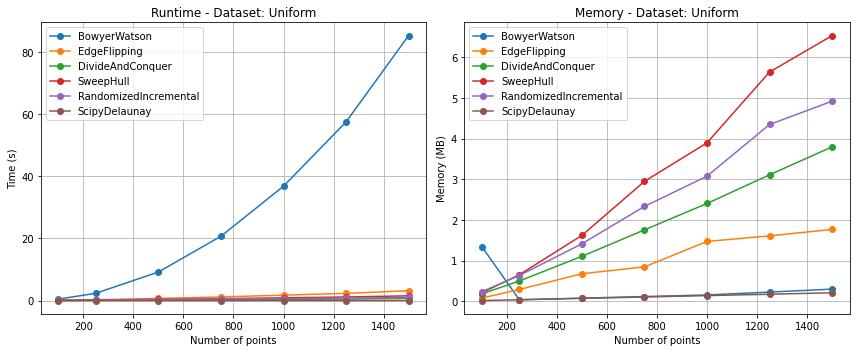

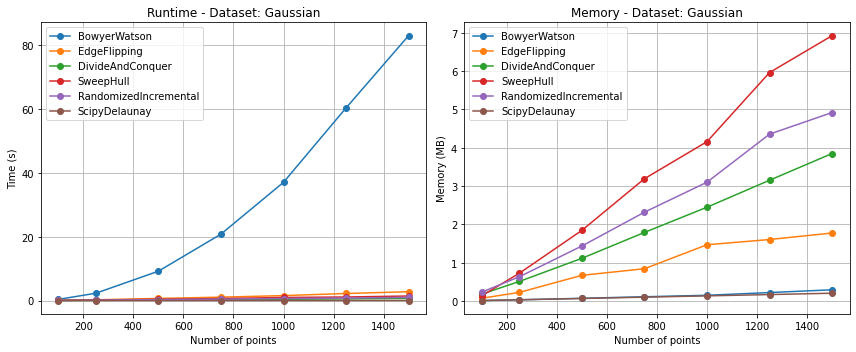

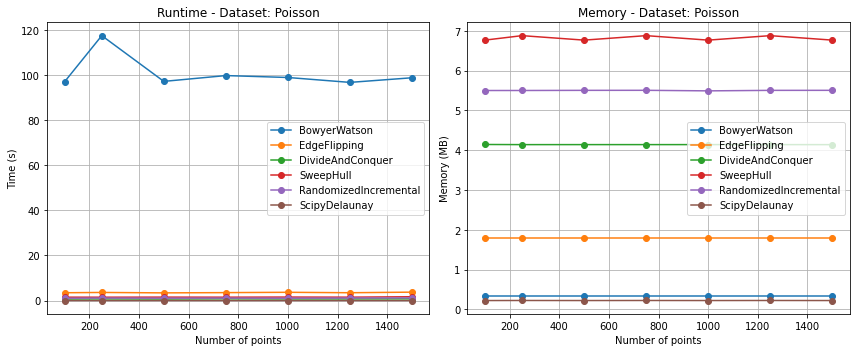

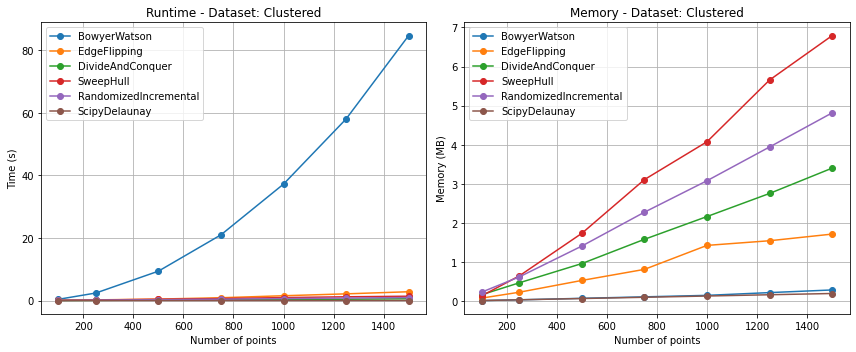

In [13]:
# Example dataset generators
seed = 42
dataset_generators = {
        "Uniform": lambda N: generate_random_points(N, x_range=(0,1), y_range=(0,1), seed=seed),
        "Gaussian": lambda N: generate_gaussian_points(N, mean=(0.5,0.5), cov=[[0.02,0],[0,0.02]], seed=seed),
        "Poisson": lambda N: generate_poisson_disc_points(radius=0.02, x_range=(0,1), y_range=(0,1), k=30, seed=seed),
        "Clustered": lambda N: generate_clustered_points(N, n_clusters=3, x_range=(0,1), y_range=(0,1), seed=seed)
}

# Your algorithms
algorithms = {
    "BowyerWatson": triangulate_bw,
    "EdgeFlipping": triangulate_flipping,
    "DivideAndConquer": triangulate_dnc,
    "SweepHull": triangulate_sh,
    "RandomizedIncremental": triangulate_ric,
    "ScipyDelaunay": Delaunay
}

point_counts = [100, 250, 500, 750, 1000, 1250, 1500]

results = benchmark_algorithms_datasets(algorithms, dataset_generators, point_counts)



--- Dataset: Uniform ---
[EdgeFlipping] N=100: time=0.0880s, memory=0.10MB
[DivideAndConquer] N=100: time=0.0371s, memory=0.18MB
[SweepHull] N=100: time=0.0618s, memory=0.20MB
[RandomizedIncremental] N=100: time=0.0512s, memory=0.23MB
[ScipyDelaunay] N=100: time=0.0010s, memory=0.01MB
[EdgeFlipping] N=250: time=0.2600s, memory=0.35MB
[DivideAndConquer] N=250: time=0.0870s, memory=0.50MB
[SweepHull] N=250: time=0.1776s, memory=0.65MB
[RandomizedIncremental] N=250: time=0.1465s, memory=0.63MB
[ScipyDelaunay] N=250: time=0.0020s, memory=0.03MB
[EdgeFlipping] N=500: time=0.7390s, memory=0.67MB
[DivideAndConquer] N=500: time=0.1745s, memory=1.10MB
[SweepHull] N=500: time=0.4432s, memory=1.62MB
[RandomizedIncremental] N=500: time=0.2916s, memory=1.40MB
[ScipyDelaunay] N=500: time=0.0021s, memory=0.07MB
[EdgeFlipping] N=750: time=1.1471s, memory=0.84MB
[DivideAndConquer] N=750: time=0.2808s, memory=1.75MB
[SweepHull] N=750: time=0.6186s, memory=2.80MB
[RandomizedIncremental] N=750: time=0.46

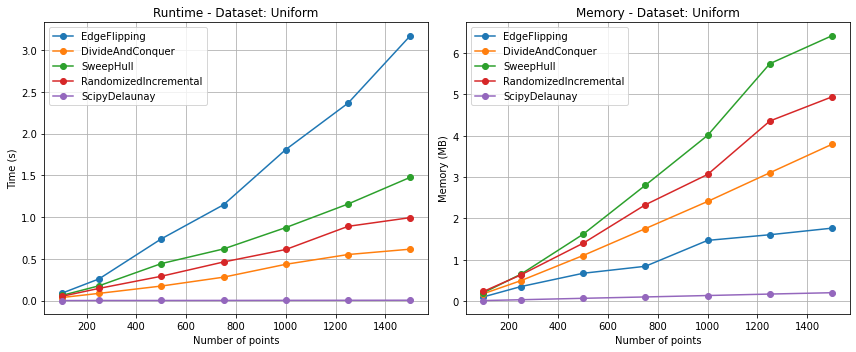

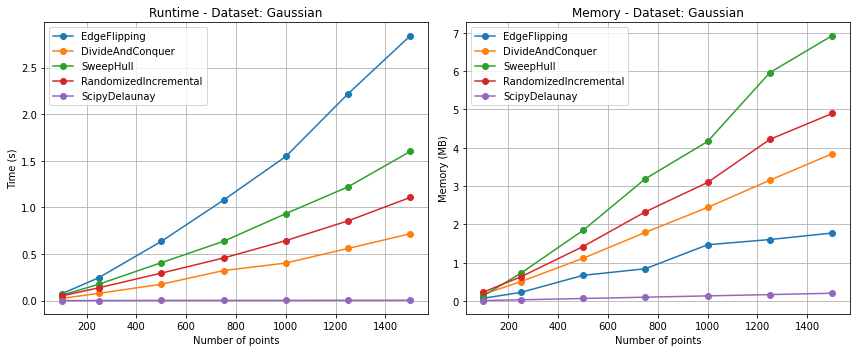

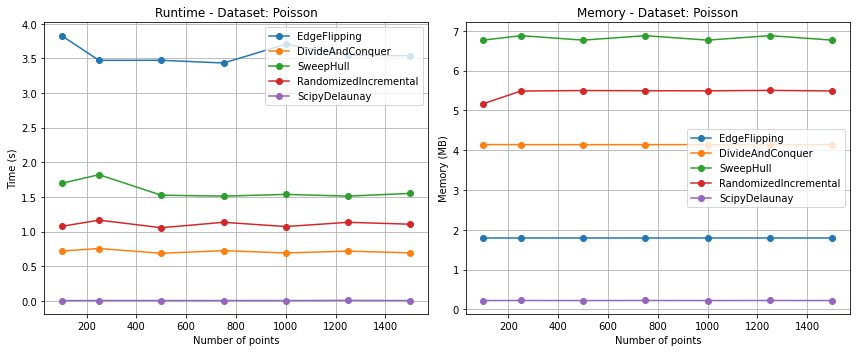

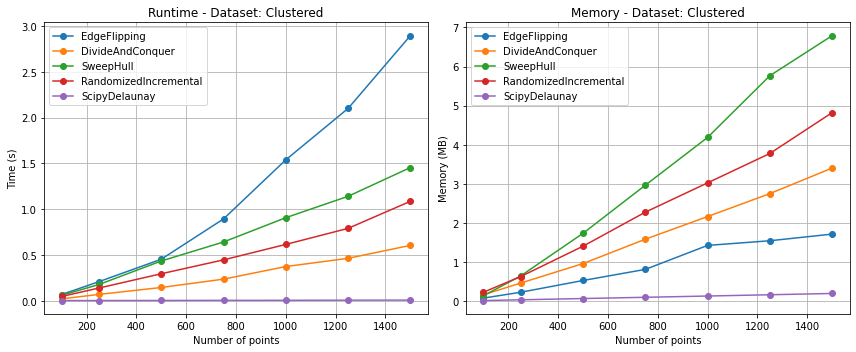

In [14]:
# Example dataset generators
seed = 42
dataset_generators = {
        "Uniform": lambda N: generate_random_points(N, x_range=(0,1), y_range=(0,1), seed=seed),
        "Gaussian": lambda N: generate_gaussian_points(N, mean=(0.5,0.5), cov=[[0.02,0],[0,0.02]], seed=seed),
        "Poisson": lambda N: generate_poisson_disc_points(radius=0.02, x_range=(0,1), y_range=(0,1), k=30, seed=seed),
        "Clustered": lambda N: generate_clustered_points(N, n_clusters=3, x_range=(0,1), y_range=(0,1), seed=seed)
}

# Your algorithms
algorithms = {
    # "BowyerWatson": triangulate_bw,
    "EdgeFlipping": triangulate_flipping,
    "DivideAndConquer": triangulate_dnc,
    "SweepHull": triangulate_sh,
    "RandomizedIncremental": triangulate_ric,
    "ScipyDelaunay": Delaunay
}

point_counts = [100, 250, 500, 750, 1000, 1250, 1500]

results = benchmark_algorithms_datasets(algorithms, dataset_generators, point_counts)
